# Librerias

In [ ]:
import os
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd
import itertools
from sklearn.metrics import r2_score
import pyodbc

# Para quitar unos warnings
warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy connectable")

# Regresión Lineal Variable Churn

## Consulta Regresion Cliente

La consulta `regresion_cliente` está diseñada para calcular una serie de métricas agregadas por cliente en función del PVP  y otras variables relacionadas. Estas métricas sirven para entender el comportamiento de compra de los clientes y estimar el valor de **Churn** (probabilidad de que un cliente abandone).

**Variables Utilizadas en la Regresión**

La regresión calcula el Churn Medio en función de diversas variables, las cuales incluyen tanto características del cliente como del producto adquirido. Las variables principales incluidas en la consulta son:

- *PVP*
- *Edad_Media_Cliente*
- *Edad_Media_Coche*
- *Renta_Media*
- *Margen_Bruto_Medio*
- *Margen_Eur_Medio*
- *Km_medio_por_revision*
- *Dias_En_Taller*
- *Churn_Medio**

In [2]:
# Conexión a SQL Server Local
LOCAL_SERVER = 'localhost'
LOCAL_DATABASE = 'dwh_case1'
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'
local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"

conn_local = pyodbc.connect(local_conn_str)

# Leer la consulta desde la carpeta "queries"
BASE_DIR = os.getcwd()
queries_path = os.path.join(BASE_DIR, "..", "queries")
regresion_file = os.path.join(queries_path, "regresion_cliente.sql")
with open(regresion_file, 'r', encoding='utf-8') as file:
    regresion_query = file.read()

# Ejecutar la consulta y guardar en DataFrame
df_reg = pd.read_sql(regresion_query, conn_local)
print(f"Filas extraídas para regresión: {df_reg.shape[0]}")
print("Columnas extraídas:", ', '.join(list(df_reg.columns)))

conn_local.close()


Filas extraídas para regresión: 1011
Columnas extraídas: PVP, Numero_Compras, Edad_Media_Cliente, Edad_Media_Coche, Margen_Bruto_Medio, Margen_Eur_Medio, Coste_Total, Renta_Media, Km_medio_por_revision, Revisiones_Medias, Coste_Venta_No_Impuestos_Medio, Dias_En_Taller, churn_medio


In [3]:
df_reg

,PVP,Numero_Compras,Edad_Media_Cliente,Edad_Media_Coche,Margen_Bruto_Medio,Margen_Eur_Medio,Coste_Total,Renta_Media,Km_medio_por_revision,Revisiones_Medias,Coste_Venta_No_Impuestos_Medio,Dias_En_Taller,churn_medio
0,10528,174,42,2.057471,2947.840088,1420.462045,1527.377921,23566,17630,0,435,1.327586,0.293103
1,10909,162,41,2.314815,3054.520020,1676.102518,1378.417502,22945,14328,0,255,3.987654,0.246913
2,11004,239,43,2.054393,3081.120117,1755.825153,1325.294842,23215,16105,0,194,0.974895,0.284518
3,11100,2,47,3.500000,3108.000000,1720.000000,1388.000000,29759,39937,2,250,0.000000,1.000000
4,11237,89,44,2.089888,3146.360107,1197.343844,1949.016141,23823,18348,0,800,0.955056,0.292134
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,36496,29,42,2.448276,12043.679688,360.542077,11683.137931,17480,7966,0,2309,1.586207,0.000000
1007,36634,329,42,2.118541,15752.620117,13577.761098,2174.859329,17932,7552,0,1192,1.340426,0.006079
1008,36771,122,40,2.188525,15811.530273,13651.938220,2159.592122,17215,9650,0,1174,2.237705,0.016393
1009,37832,12,42,2.416667,12484.559570,213.310008,12271.250000,15680,7322,0,2563,0.416667,0.000000


## Correlación Variables con Churn

En la siguiente matriz estudiamos la correlación de todas las variables que hemos seleccionado con la objetivo que es Churn_medio.

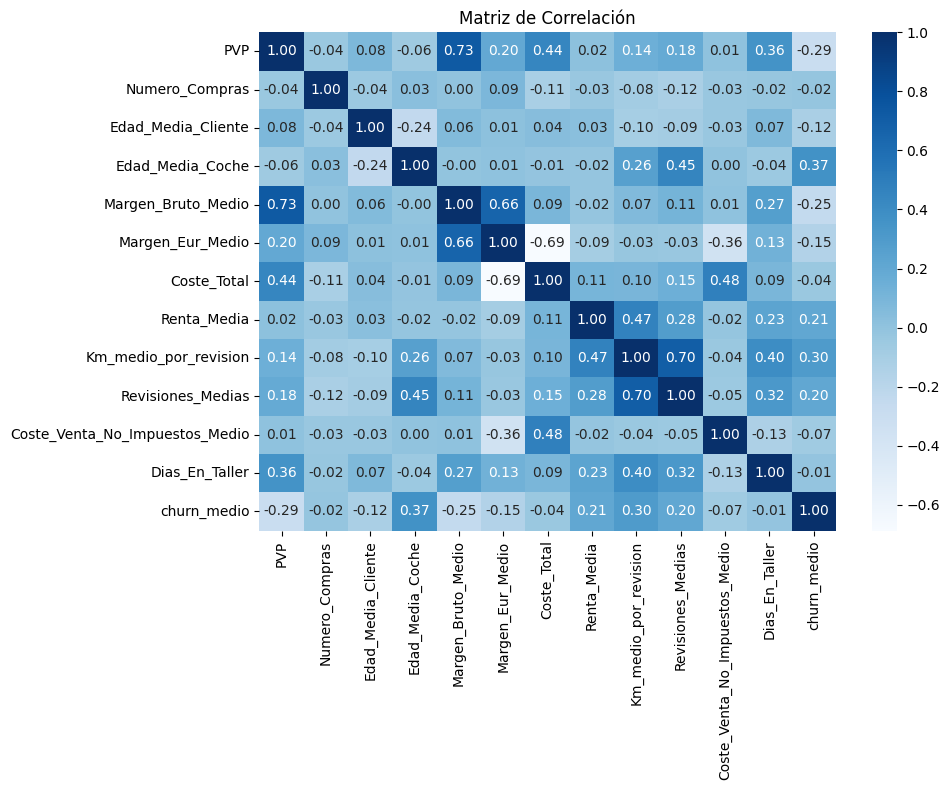

In [4]:
corr_matrix = df_reg.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()


## Regresión Lineal

El objetivo de este análisis es entrenar regresiones lineales utilizando diferentes combinaciones de 4 variables para predecir la variable Churn Medio. Se selecciona la combinación con el **mayor R²**, ya que esto indica que el modelo explica mejor la variabilidad de la variable dependiente (Churn Medio).

In [5]:
# Variables candidatas
variables = ['PVP', 'Numero_Compras', 'Edad_Media_Cliente', 'Edad_Media_Coche',
       'Margen_Bruto_Medio', 'Margen_Eur_Medio', 'Coste_Total', 'Renta_Media',
       'Km_medio_por_revision', 'Revisiones_Medias',
       'Coste_Venta_No_Impuestos_Medio', 'Dias_En_Taller']

objetivo = "churn_medio"
resultados = []

combinaciones = list(itertools.combinations(variables, 4))

for vars_comb in combinaciones:
    X = df_reg[list(vars_comb)]
    y = df_reg[objetivo]

    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)

    r2 = r2_score(y, y_pred)
    resultados.append((vars_comb, r2))

# Mostrar las mejores combinaciones ordenadas por R²
resultados.sort(key=lambda x: x[1], reverse=True)

print("Ranking de combinaciones por R²:\n")
for i, (vars_comb, r2) in enumerate(resultados[:5], 1):
    print(f"{i}. Variables: {vars_comb} → R²: {r2:.4f}")


Ranking de combinaciones por R²:

1. Variables: ('PVP', 'Edad_Media_Coche', 'Renta_Media', 'Km_medio_por_revision') → R²: 0.2818
2. Variables: ('PVP', 'Edad_Media_Coche', 'Margen_Eur_Medio', 'Km_medio_por_revision') → R²: 0.2792
3. Variables: ('PVP', 'Edad_Media_Coche', 'Coste_Total', 'Km_medio_por_revision') → R²: 0.2785
4. Variables: ('PVP', 'Edad_Media_Coche', 'Km_medio_por_revision', 'Revisiones_Medias') → R²: 0.2782
5. Variables: ('PVP', 'Edad_Media_Coche', 'Margen_Bruto_Medio', 'Km_medio_por_revision') → R²: 0.2746


**Selección mejor Regresión Lineal**

Este código selecciona automáticamente la mejor combinación de 4 variables entre las posibles para predecir la variable dependiente churn_medio utilizando una regresión lineal

In [6]:
# Lista de todas las variables posibles
variables = ['PVP', 'Numero_Compras', 'Edad_Media_Cliente', 'Edad_Media_Coche',
       'Margen_Bruto_Medio', 'Margen_Eur_Medio', 'Coste_Total', 'Renta_Media',
       'Km_medio_por_revision', 'Revisiones_Medias',
       'Coste_Venta_No_Impuestos_Medio', 'Dias_En_Taller']

#Inicializar parámetros
best_r2 = -1
best_combination = None

# Probar todas las combinaciones de 4 variables
for comb in itertools.combinations(variables, 4):
    X = df_reg[list(comb)]  
    y = df_reg['churn_medio']  

  
    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    if r2 > best_r2:
        best_r2 = r2
        best_combination = comb



print("Mejor combinación de variables:", best_combination)
print("Mejor R²:", best_r2)

Mejor combinación de variables: ('PVP', 'Edad_Media_Coche', 'Renta_Media', 'Km_medio_por_revision')
Mejor R²: 0.2817600305305372


**Entrenamiento del modelo**

A continuación, se va a expresar la variable `churn` en función de las variables seleccionadas en la regresión lineal. El modelo de regresión lineal tiene la siguiente forma:

$
\text{churn} = \text{intercepto} + a_1 \cdot \text{variable}_1 + a_2 \cdot \text{variable}_2 + a_3 \cdot \text{variable}_3 + a_4 \cdot \text{variable}_4
$

In [7]:
X_best = df_reg[list(best_combination)]  # Variables con la mejor combinación
y_best = df_reg['churn_medio']  

model = LinearRegression()
model.fit(X_best, y_best)

# Mostrar los coeficientes y el intercepto del modelo
coeficientes = model.coef_
intercepto = model.intercept_

print("Coeficientes:")
for i, col in enumerate(best_combination):
    print(f"{col}: {coeficientes[i]}")

print(f"Intercepto: {intercepto}")

Coeficientes:
PVP: -8.265690621992885e-06
Edad_Media_Coche: 0.06317382344234546
Renta_Media: 2.7729421245917263e-06
Km_medio_por_revision: 2.9624506008851803e-06
Intercepto: 0.06400985708416444


## Guardar los coeficientes Regresión SSMS

In [ ]:
# Conexión a SQL Server Local
LOCAL_SERVER = 'localhost'  # Servidor local
LOCAL_DATABASE = 'dwh_case1'  # Base de datos local
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'

# Cadena de conexión para SQL Server local
local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"

# Conectar a SQL Server Local
conn_local = pyodbc.connect(local_conn_str)
cursor_local = conn_local.cursor()


In [9]:
coeficientes = model.coef_
intercepto = model.intercept_
variables = best_combination

# Crear DataFrame con resultados
df_resultados = pd.DataFrame({
    'Variable': list(variables) + ['Intercepto'],
    'Valor': list(coeficientes) + [intercepto]
})

df_resultados

,Variable,Valor
0,PVP,-0.000008
1,Edad_Media_Coche,0.063174
2,Renta_Media,0.000003
3,Km_medio_por_revision,0.000003
4,Intercepto,0.064010


In [10]:
# Crear la tabla para almacenar los resultados de la regresión
create_table_sql = """
CREATE TABLE  regresion_coef(
    Variable NVARCHAR(255),
    Coeficiente FLOAT,
    Intercepto FLOAT
);
"""

cursor_local.execute(create_table_sql)
conn_local.commit()


In [13]:
try:
    conn_local = pyodbc.connect(local_conn_str)
    cursor = conn_local.cursor()

    # Eliminar tabla si ya existe
    cursor.execute("DROP TABLE IF EXISTS Regresion_Coeficientes")
    conn_local.commit()

    # Crear tabla
    create_table_sql = """
    CREATE TABLE Regresion_Coeficientes (
        Variable NVARCHAR(255),
        Valor FLOAT
    );
    """
    cursor.execute(create_table_sql)
    conn_local.commit()

    # Insertar resultados
    insert_sql = "INSERT INTO Regresion_Coeficientes (Variable, Valor) VALUES (?, ?)"
    cursor.fast_executemany = True
    cursor.executemany(insert_sql, df_resultados.values.tolist())
    conn_local.commit()

    print("✅ Tabla Regresion_Coeficientes creada e insertada correctamente.")

except Exception as e:
    print(f"❌ Error: {e}")

finally:
    if 'conn_local' in locals():
        conn_local.close()

✅ Tabla Regresion_Coeficientes creada e insertada correctamente.
